In [3]:
# importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [4]:
# Reading the file
df = pd.read_csv('wine-reviews.csv', usecols = ['country', 'description',  'points', 'price', 'variety', 'winery'])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [6]:
# droping null values from description and pointa columns
df = df.dropna(subset= ['description', "points"])

In [7]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


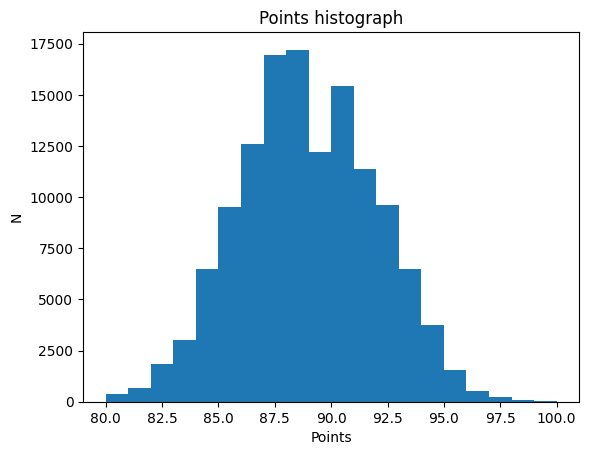

In [8]:
# indentifying the range of the points by looking at the histograph
plt.hist(df.points, bins =20)
plt.title('Points histograph')
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

from the graph we can say that the range pf points lies brtween 80 and 100.

In [9]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [10]:
train, val , test = np.split(df.sample(frac =1), [int(0.8*len(df)), int(0.9*len(df))])

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

#embedding + model

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype = tf.string ,trainable = True )

In [14]:
# building model
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [16]:
model.evaluate(train_data)

102/102 [==============================] - 2s 13ms/step - loss: 0.7018 - accuracy: 0.4104


[0.7018264532089233, 0.41036394238471985]

In [17]:
model.evaluate(val_data)

13/13 [==============================] - 0s 16ms/step - loss: 0.7026 - accuracy: 0.4064


[0.7025988101959229, 0.40640148520469666]

In [16]:
history = model.fit(train_data, epochs =10, validation_data= val_data)

Epoch 1/10
102/102 [==============================] - 201s 2s/step - loss: 0.6150 - accuracy: 0.6521 - val_loss: 0.4743 - val_accuracy: 0.7899
Epoch 2/10
102/102 [==============================] - 180s 2s/step - loss: 0.4605 - accuracy: 0.7888 - val_loss: 0.3966 - val_accuracy: 0.8195
Epoch 3/10
102/102 [==============================] - 181s 2s/step - loss: 0.3927 - accuracy: 0.8290 - val_loss: 0.3806 - val_accuracy: 0.8232
Epoch 4/10
102/102 [==============================] - 198s 2s/step - loss: 0.3619 - accuracy: 0.8451 - val_loss: 0.3764 - val_accuracy: 0.8282
Epoch 5/10
102/102 [==============================] - 166s 2s/step - loss: 0.3398 - accuracy: 0.8555 - val_loss: 0.3801 - val_accuracy: 0.8289
Epoch 6/10
102/102 [==============================] - 148s 1s/step - loss: 0.3195 - accuracy: 0.8650 - val_loss: 0.3879 - val_accuracy: 0.8326
Epoch 7/10
102/102 [==============================] - 166s 2s/step - loss: 0.2994 - accuracy: 0.8734 - val_loss: 0.3922 - val_accuracy: 0.8316

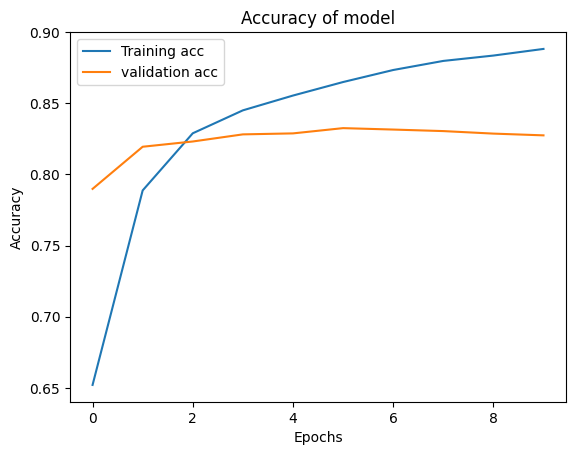

In [20]:
plt.plot(history.history['accuracy'], label = "Training acc")
plt.plot(history.history['val_accuracy'], label = "validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

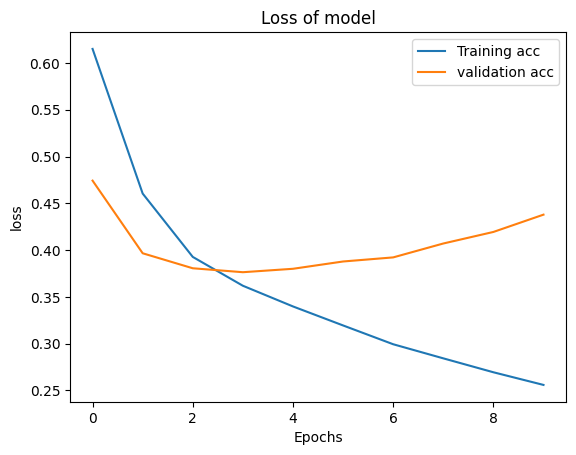

In [21]:
plt.plot(history.history['loss'], label = "Training acc")
plt.plot(history.history['val_loss'], label = "validation acc")
plt.title("Loss of model")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

#LSTM

In [20]:
encoder = tf.keras.layers.TextVectorization(max_tokens= 2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [21]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [26]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation = 'sigmoid')

])

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [28]:
model.evaluate(train_data)
model.evaluate(val_data)

13/13 [==============================] - 2s 175ms/step - loss: 0.6932 - accuracy: 0.4874


[0.6932469606399536, 0.4874201714992523]

In [29]:
history = model.fit(train_data, epochs =5 , validation_data = val_data)

Epoch 1/5
102/102 [==============================] - 65s 569ms/step - loss: 0.5429 - accuracy: 0.7161 - val_loss: 0.3877 - val_accuracy: 0.8203
Epoch 2/5
102/102 [==============================] - 62s 613ms/step - loss: 0.3679 - accuracy: 0.8372 - val_loss: 0.3552 - val_accuracy: 0.8360
Epoch 3/5
102/102 [==============================] - 57s 549ms/step - loss: 0.3482 - accuracy: 0.8456 - val_loss: 0.3529 - val_accuracy: 0.8367
Epoch 4/5
102/102 [==============================] - 55s 534ms/step - loss: 0.3421 - accuracy: 0.8482 - val_loss: 0.3572 - val_accuracy: 0.8367
Epoch 5/5
102/102 [==============================] - 56s 539ms/step - loss: 0.3379 - accuracy: 0.8493 - val_loss: 0.3516 - val_accuracy: 0.8374


In [30]:
model.evaluate(test_data)

13/13 [==============================] - 5s 356ms/step - loss: 0.3558 - accuracy: 0.8400


[0.35581400990486145, 0.8399753570556641]